<a href="https://colab.research.google.com/github/francescopatane96/Computer_aided_drug_discovery_kit/blob/main/3_filtering_substructures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#3. Unwanted substructures

Some substructures can be reactive or toxic or they can interfere with certain assays. Filtering unwanted substructures can support assembling more efficient screening libraries, which can save time and resources.
Examples of such unwanted features are nitro groups (mutagenic), sulfates and phosphates (likely resulting in unfavorable pharmacokinetic properties), 2-halopyridines and thiols (reactive).


Pan Assay Interference Compounds (PAINS):
compounds that often occur as hits in HTS even though they actually are false positives. PAINS show activity at numerous targets rather than one specific target.

In [ ]:
!pip install rdkit

In [2]:
from pathlib import Path

import pandas as pd
from tqdm.auto import tqdm
from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem.FilterCatalog import FilterCatalog, FilterCatalogParams

In [4]:
# load data from Talktorial T2
TNFB_data = pd.read_csv(
    "compounds_lipinski.csv",
    index_col=0,
)
# Drop unnecessary information
print("Dataframe shape:", TNFB_data.shape)
TNFB_data.drop(columns=["molecular_weight", "n_hbd", "n_hba", "logp"], inplace=True)
TNFB_data.head()

Dataframe shape: (5431, 11)


,molecule_chembl_id,IC50,units,smiles,pIC50,ROMol,ro5_fulfilled
0,CHEMBL63786,0.003,nM,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879,<rdkit.Chem.rdchem.Mol object at 0x78dddbff6ff0>,True
1,CHEMBL53711,0.006,nM,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849,<rdkit.Chem.rdchem.Mol object at 0x78dddbffa7a0>,True
2,CHEMBL35820,0.006,nM,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849,<rdkit.Chem.rdchem.Mol object at 0x78dddc005930>,True
3,CHEMBL53753,0.008,nM,CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.096910,<rdkit.Chem.rdchem.Mol object at 0x78dddc0035a0>,True
4,CHEMBL66031,0.008,nM,Brc1cccc(Nc2ncnc3cc4[nH]cnc4cc23)c1,11.096910,<rdkit.Chem.rdchem.Mol object at 0x78dddbffcb30>,True


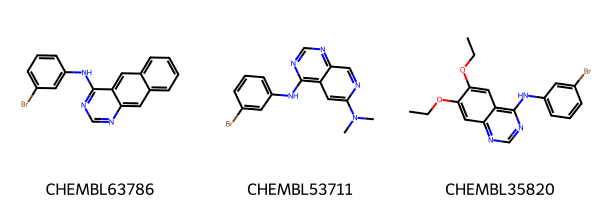

In [5]:
# Add molecule column
PandasTools.AddMoleculeColumnToFrame(TNFB_data, smilesCol="smiles")
# Draw first 3 molecules
Chem.Draw.MolsToGridImage(
    list(TNFB_data.head(3).ROMol),
    legends=list(TNFB_data.head(3).molecule_chembl_id),
)

## Filter for Pan Assay Interference Compounds (PAINS)

In [6]:
# initialize filter
params = FilterCatalogParams()
params.AddCatalog(FilterCatalogParams.FilterCatalogs.PAINS)
catalog = FilterCatalog(params)

In [7]:
# search for Pan Assay Interference Compounds (PAINS)
matches = []
clean = []
for index, row in tqdm(TNFB_data.iterrows(), total=TNFB_data.shape[0]):
    molecule = Chem.MolFromSmiles(row.smiles)
    entry = catalog.GetFirstMatch(molecule)  # Get the first matching PAINS
    if entry is not None:
        # store PAINS information
        matches.append(
            {
                "chembl_id": row.molecule_chembl_id,
                "rdkit_molecule": molecule,
                "pains": entry.GetDescription().capitalize(),
            }
        )
    else:
        # collect indices of molecules without PAINS
        clean.append(index)

matches = pd.DataFrame(matches)
TNFB_data = TNFB_data.loc[clean]  # keep molecules without PAINS

  0%|          | 0/5431 [00:00<?, ?it/s]

In [8]:
print(f"Number of compounds with PAINS: {len(matches)}")
print(f"Number of compounds without PAINS: {len(TNFB_data)}")

Number of compounds with PAINS: 490
Number of compounds without PAINS: 4941


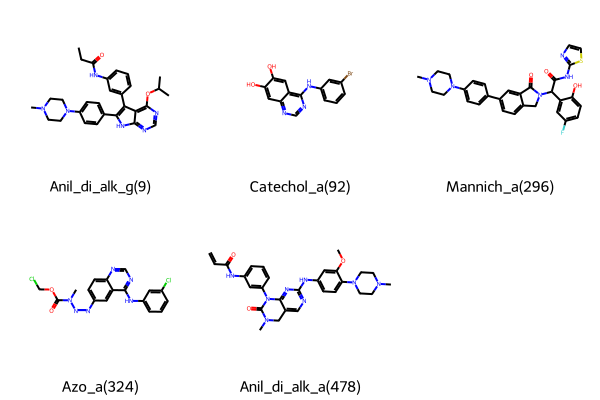

In [9]:
Chem.Draw.MolsToGridImage(
    list(matches.head(5).rdkit_molecule),
    legends=list(matches.head(5)["pains"]),
)

## Filter and highlight unwanted substructures

This step removes molecules containing substructures with undesirable pharmacokinetics or toxicity. These include sulfates and phosphates that contribute to unfavourable pharmacokinetics, nitro groups which are mutagenic and 2-halopyridines and thiols which are both reactive, groups with reactive functionalities (including Michael acceptors, aldehydes, epoxides, alkyl halides, metals, 2-halo pyridines, phosphorus nitrogen bonds, α-chloroketones and β-lactams) and medicinal chemistry exclusions (including oximes, crown ethers, hydrazines, flavanoids, polyphenols, primary halide sulfates and multiple nitro groups).

In [15]:
substructures = pd.read_csv("unwanted_subs.csv", sep=",")
substructures["rdkit_molecule"] = substructures.Smarts.apply(Chem.MolFromSmarts)
print("Number of unwanted substructures in collection:", len(substructures))
# NBVAL_CHECK_OUTPUT

Number of unwanted substructures in collection: 3


In [16]:
substructures

,Name,Smarts,rdkit_molecule
0,> 2 ester groups,"C(=O)O[C,H1].C(=O)O[C,H1].C(=O)O[C,H1]",<rdkit.Chem.rdchem.Mol object at 0x796631eb1cb0>
1,2-halo pyridine,"n1c([F,Cl,Br,I])cccc1",<rdkit.Chem.rdchem.Mol object at 0x796631eb1d20>
2,acid halide,"C(=O)[Cl,Br,I,F]",<rdkit.Chem.rdchem.Mol object at 0x796631eb18c0>


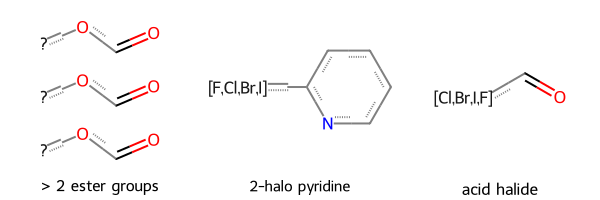

In [19]:
Chem.Draw.MolsToGridImage(
    mols=substructures.rdkit_molecule.tolist()[:5],
    legends=substructures.Name.tolist()[:5],
)

In [ ]:
# search for unwanted substructure
matches = []
clean = []
for index, row in tqdm(TNFB_data.iterrows(), total=TNFB_data.shape[0]):
    molecule = Chem.MolFromSmiles(row.smiles)
    match = False
    for _, substructure in substructures.iterrows():
        if molecule.HasSubstructMatch(substructure.rdkit_molecule):
            matches.append(
                {
                    "chembl_id": row.molecule_chembl_id,
                    "rdkit_molecule": molecule,
                    "substructure": substructure.rdkit_molecule,
                    "substructure_name": substructure["Name"],
                }
            )
            match = True
    if not match:
        clean.append(index)

matches = pd.DataFrame(matches)
TNFB_data = TNFB_data.loc[clean]

In [25]:
# NBVAL_CHECK_OUTPUT
print(f"Number of found unwanted substructure: {len(matches)}")
print(f"Number of compounds without unwanted substructure: {len(TNFB_data)}")

Number of found unwanted substructure: 25
Number of compounds without unwanted substructure: 4916


## Highlight substructures

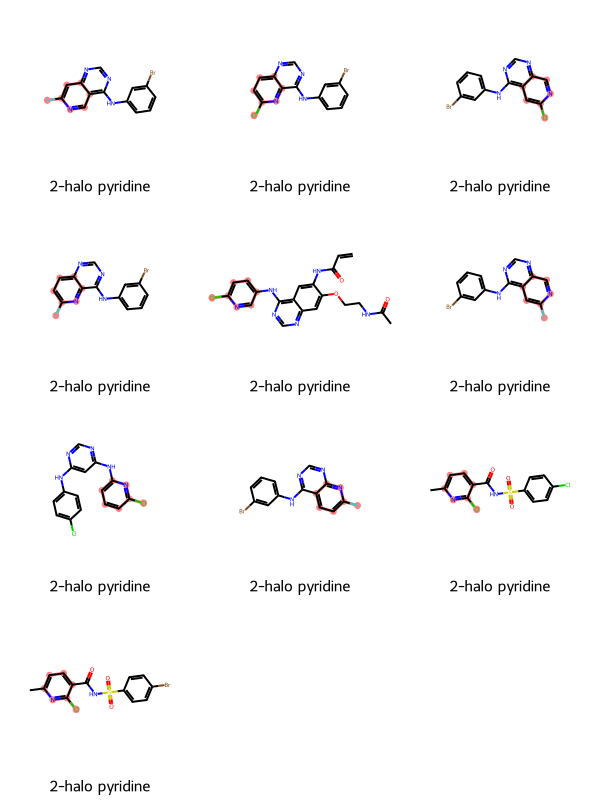

In [27]:
to_highlight = [
    row.rdkit_molecule.GetSubstructMatch(row.substructure) for _, row in matches.head(10).iterrows()
]
Chem.Draw.MolsToGridImage(
    list(matches.head(10).rdkit_molecule),
    highlightAtomLists=to_highlight,
    legends=list(matches.head(10).substructure_name),
)

## Substructure statistics

In [28]:
# NBVAL_CHECK_OUTPUT
groups = matches.groupby("substructure_name")
group_frequencies = groups.size()
group_frequencies.sort_values(ascending=False, inplace=True)
group_frequencies.head(10)

substructure_name
2-halo pyridine    25
dtype: int64